# BAKU - Time Measurement and Code Generation
![Baku.png](../assets/images/Banner.png)

This notebook is designed for testing language models (LLMs). The primary objective is to collect data on the performance of LLMs regarding the time spent on code generation, the percentage of generated code that can be compiled, and determine the asymptotic behavior of time concerning the maximum number of tokens in the networks. The original and functional notebook works in Google colab, this copy is only for version management.

### Imports

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
) #the model

import torch #for the model
import numpy as np #to better use of the arrays
import time
import matplotlib.pyplot as plt
import pandas as pd #for csv
import statsmodels.stats.api as sms
from google.colab import drive #to import the csv
import subprocess
import random
import string

In [ ]:
llvm_path = '/content/drive/MyDrive/Colab_Notebooks/BenchGen/llvm_assembly_characteristics.csv'
models_path = '/content/drive/MyDrive/Colab_Notebooks/BenchGen/models_data.csv'

drive.mount('/content/drive')
llvm_characteristics = pd.read_csv(llvm_path)
models_data = pd.read_csv(models_path)

In [ ]:
# model_name = "codellama/CodeLlama-7b-hf" #Obs: Run in free plan; Some alucinations (tuning?);
model_name = 'deepseek-ai/DeepSeek-Coder-V2-Lite-Base' #Obs: Don't Run in free; Clean code; Faster;
# model_name = 'bigcode/starcoder2-7b' #Obs: Lazy; Alucinations; Bigger than llama;
# model_name = 'facebook/llvm-compiler-7b'#Need to be test properly

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code = True,
    torch_dtype = torch.bfloat16
).cuda()

input_text = "write a quick sort algorithm in C"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Functions

In [ ]:
def get_detailed_gpu_info():
    try:
        # All the informations about the current GPU
        gpu_info = subprocess.check_output(
            'nvidia-smi --query-gpu=name,driver_version,memory.total,memory.used,memory.free,utilization.gpu --format=csv,noheader',
            shell=True, text=True
        )
        return gpu_info.strip()
    except Exception as e:
        print(f"Erro ao obter informações detalhadas da GPU: {e}")
        return "Unkown"

In [ ]:
def name_generator(model_values,size=4, chars=string.ascii_uppercase + string.digits):
  random_name = ''.join(random.choice(chars) for _ in range(size))
  while random_name in model_values['code_name'].values:
    random_name = ''.join(random.choice(chars) for _ in range(size))
  return random_name

In [ ]:
def update_model_value(dif_minutes,input_text,max_length,output):

    model_values_path = '/content/drive/MyDrive/Colab_Notebooks/BenchGen/model_values.csv'
    models_values = pd.read_csv(model_values_path)

    gpu_details = get_detailed_gpu_info()
    gpu_name = gpu_details.split(',')[0]

    code_name = name_generator(models_values)

    code_path = f'/content/drive/MyDrive/Colab_Notebooks/BenchGen/codes/{code_name}.c'

    code_file = open("code_path", "w")
    code_file.write(output)
    code_file.close()

    new_row = pd.DataFrame({
        'model_name' : [model_name],
        'seconds' : [dif_minutes],
        'code_name' : [code_name], #random name generator
        'max_length' : [max_length],
        'gpu_name' : [gpu_name],
        'caracteristcs' : [input_text], #I don't know how ...
        'accuracy' : [0]

    })

    models_values = pd.concat([models_data, new_row], ignore_index=True)

    models_values.to_csv(models_path, index=False)

      # pick time of every single value - OK
      # code export (/codes) - Maybe?
      # accuracy code copilation - Need python script to compile
      # max length - OK
      # gpu name - OK
      # caracteristcs of the code - No


In [ ]:
def generate_code(input_text,max_length,model,response=True):
  #template prompt (comand,caracteristcs,size,)
  template_prompt = f"Do me a code in c for compilers, with {max_length} tokens, that contains {input_text}. Without coments, please."
  #What are the desirable caracteristcs? Need to add them to the LLVM code randomizer

  input_time = time.time()
  inputs = tokenizer(template_prompt, return_tensors="pt").to(model.device)
  outputs = model.generate(**inputs, max_length=max_length)
  output_time = time.time()
  dif_minutes = (output_time - input_time)
  decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

  if(response):
    print(decoded_output)
    print(f'Time spend in the code generation: {dif_minutes}')
  else:
    update_model_value(dif_minutes,max_length,decoded_output)

  return dif_minutes,decoded_output

### Generation Tests

In [ ]:
time_response = generate_code("1% branch mispredictions",1024,model,response=False)
time_response

In [ ]:
time_response = generate_code("20% cache misses",2048,model)
time_response

### Simulations

In [ ]:
def simulation_model(models_data=models_data,first_max_length=1024,max_lenght_pow=1,sample=12):

  current_max_length = first_max_length
  time_array = np.array([])

  for i in range(max_lenght_pow):

    for j in range(sample):
      random_string = llvm_characteristics.sample().get('Characteristic').iloc[0]

      time_temp,decoded_output = generate_code(random_string,current_max_length,model,response=False)

      time_array = np.append(time_array,time_temp)


    new_row = pd.DataFrame({
        'model' : [model_name],
        'mean_seconds': [np.mean(time_array)],
        'std_seconds': [np.std(time_array)],
        'sample_size': [sample],
        'text_length': [current_max_length],
        'lower_value': [np.min(time_array)],
        'higher_value': [np.max(time_array)]
    })

    models_data = pd.concat([models_data, new_row], ignore_index=True)

    models_data.to_csv(models_path, index=False)

    time_array = np.empty(0)

    current_max_length *= 2

  return models_data

In [ ]:
models_data = simulation_model(models_data,first_max_length=1024,max_lenght_pow=1,sample=10)

### Stats and DataFrame

In [ ]:
models_data

,model,mean_seconds,std_seconds,sample_size,text_length,lower_value,higher_value
0,codellama/CodeLlama-7b-hf,7.460466,0.412956,20,128,7.214905,9.054687
1,codellama/CodeLlama-7b-hf,15.587704,0.064352,20,256,15.499170,15.717568
2,codellama/CodeLlama-7b-hf,33.195767,0.152024,20,512,32.581870,33.311173
3,codellama/CodeLlama-7b-hf,70.612746,8.715631,20,1024,32.623131,72.744761


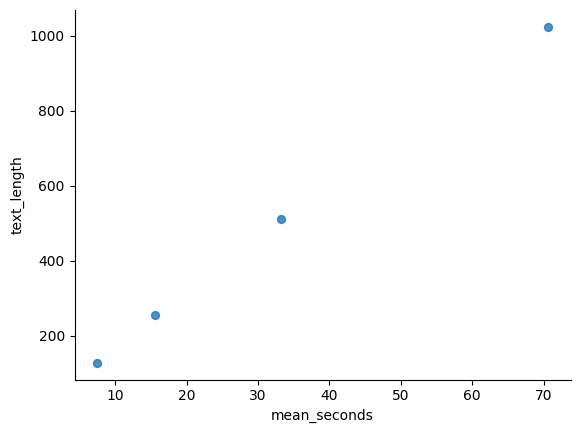

In [ ]:
models_data.plot(kind='scatter', x='mean_seconds', y='text_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)